# NB01: Metabolic Dependency Mapping

**Project**: Aromatic Catabolism Support Network in ADP1

**Goal**: Trace cofactor requirements through the β-ketoadipate pathway, compare FBA-predicted essentiality across aromatic vs non-aromatic carbon sources, and test whether the FBA model predicts the quinate-specificity of Complex I.

**Inputs**:
- `data/quinate_specific_genes.csv` — 51 quinate-specific genes from adp1_deletion_phenotypes
- `user_data/berdl_tables.db` — FBA predictions (gene_phenotypes, 230 conditions)

**Outputs**:
- FBA aromatic vs non-aromatic comparison
- Pathway cofactor requirement annotations
- FB aromatic experiment feasibility check

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os

DATA_DIR = '../data'
FIG_DIR = '../figures'
DB_PATH = '../user_data/berdl_tables.db'

# Load the 51 quinate-specific genes
qs = pd.read_csv(os.path.join(DATA_DIR, 'quinate_specific_genes.csv'))
print(f'Quinate-specific genes: {len(qs)}')

# Assign functional categories
def categorize_gene(row):
    func = str(row['rast_function']) if pd.notna(row['rast_function']) else ''
    if 'NADH' in func and ('ubiquinone' in func or 'oxidoreductase chain' in func):
        return 'Complex I'
    elif any(kw in func.lower() for kw in ['protocatechuate', 'catechol', 'muconate', 
             'ketoadipate', 'quinate', 'dehydroquinate']):
        return 'Aromatic pathway'
    elif 'PQQ' in func or 'pyrroloquinoline' in func.lower():
        return 'PQQ biosynthesis'
    elif any(kw in func.lower() for kw in ['siderophore', 'iron', 'exbd', 'tolr', 
             'ferrichrome', 'tonb']):
        return 'Iron acquisition'
    elif 'regulator' in func.lower() or 'regulatory' in func.lower():
        return 'Regulation'
    elif 'hypothetical' in func.lower() or 'DUF' in func or 'Uncharacterized' in func:
        return 'Unknown'
    else:
        return 'Other'

qs['category'] = qs.apply(categorize_gene, axis=1)
print('\nFunctional categories:')
print(qs['category'].value_counts().to_string())

Quinate-specific genes: 51

Functional categories:
category
Other               20
Complex I           10
Aromatic pathway     6
Regulation           6
Iron acquisition     4
Unknown              3
PQQ biosynthesis     2


## 1. Pathway Cofactor Requirements

Trace quinate catabolism step by step, annotating cofactor/electron requirements:

```
Quinate
  │ quiA (PQQ-dependent dehydrogenase) → requires PQQ cofactor
  ▼
3-Dehydroquinate  
  │ quiB (dehydratase)
  ▼
3-Dehydroshikimate → Protocatechuate
  │ pcaGH (3,4-dioxygenase) → requires Fe²⁺, consumes O₂
  ▼
β-Carboxy-cis,cis-muconate
  │ pcaB (cycloisomerase)
  ▼
γ-Carboxymuconolactone  
  │ pcaC (decarboxylase)
  ▼
β-Ketoadipate enol-lactone
  │ pcaD (hydrolase)
  ▼
β-Ketoadipate
  │ pcaIJ (transferase) → generates succinyl-CoA
  │ pcaF (thiolase) → generates acetyl-CoA
  ▼
Succinyl-CoA + Acetyl-CoA → TCA cycle → NADH → Complex I → ATP
```

In [2]:
# The pathway produces NADH at multiple TCA cycle steps.
# Let's check what the FBA model says about flux through these genes
# on aromatic vs non-aromatic substrates.

conn = sqlite3.connect(DB_PATH)

# Get gene-reaction mappings for quinate-specific genes
qs_ids = qs['feature_id'].tolist()
placeholders = ','.join(['?'] * len(qs_ids))

gene_rxns = pd.read_sql_query(f'''
    SELECT gene_id, reaction, minimal_media_flux, minimal_media_class
    FROM gene_reaction_data
    WHERE gene_id IN ({placeholders})
''', conn, params=qs_ids)

print(f'Gene-reaction mappings for quinate-specific genes: {len(gene_rxns)}')
print(f'Genes with reactions: {gene_rxns["gene_id"].nunique()} / {len(qs_ids)}')

# Which genes have NO reaction mappings? These are the support genes
genes_with_rxns = set(gene_rxns['gene_id'])
genes_without = qs[~qs['feature_id'].isin(genes_with_rxns)]
print(f'\nGenes WITHOUT FBA reaction mappings ({len(genes_without)}):')
for _, row in genes_without.iterrows():
    locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
    print(f'  {locus:15s} [{row["category"]:18s}] {str(row["rast_function"])[:55]}')

conn.close()

Gene-reaction mappings for quinate-specific genes: 21
Genes with reactions: 21 / 51

Genes WITHOUT FBA reaction mappings (30):
  ACIAD2505       [PQQ biosynthesis  ] Pyrroloquinoline-quinone synthase (EC 1.3.3.11)
  ACIAD2506       [PQQ biosynthesis  ] Coenzyme PQQ synthesis protein D
  ACIAD1590       [Iron acquisition  ] Biopolymer transport protein ExbD/TolR
  ACIAD3137       [Other             ] UPF0234 protein Yitk
  ACIAD2176       [Unknown           ] DUF2280 domain-containing protein
  ACIAD2124       [Iron acquisition  ] Uncharacterized siderophore S biosynthesis protein, Acs
  ACIAD2741       [Other             ] Phage capsid and scaffold
  ACIAD1818       [Other             ] 3-methylmercaptopropionyl-CoA ligase (EC 6.2.1.44) of D
  ACIAD2066       [Other             ] Coenzyme F420-dependent N5,N10-methylene tetrahydrometh
  ACIAD1648       [Regulation        ] Leucine-responsive regulatory protein, regulator for le
  ACIAD0090       [Other             ] Glycosyl transferas

## 2. FBA Predictions: Aromatic vs Non-Aromatic Carbon Sources

The `gene_phenotypes` table contains FBA flux predictions for each gene across 230 carbon sources, including 9 aromatic compounds. Compare predicted essentiality of the 51 quinate-specific genes on aromatics vs non-aromatics.

In [3]:
conn = sqlite3.connect(DB_PATH)

# Define aromatic vs non-aromatic conditions
AROMATIC_CONDITIONS = [
    'Quinic Acid', 'Protocatechuate', 'Benzoate', 
    '4 Hydroxy Benzoic Acid', '2 Hydroxy Benzoic Acid',
    'Vanillin', 'Vanillate', '4-Coumarate', 'Ferulate'
]
NON_AROMATIC_CONDITIONS = [
    'D Glucose', 'Acetic Acid', 'L Asparagine', 'L Lactic Acid',
    'Succinic Acid', 'Pyruvic Acid', 'Glycerol', 'Citric Acid'
]

# Get FBA predictions for all quinate-specific genes
all_conditions = AROMATIC_CONDITIONS + NON_AROMATIC_CONDITIONS
cond_placeholders = ','.join(['?'] * len(all_conditions))
gene_placeholders = ','.join(['?'] * len(qs_ids))

fba = pd.read_sql_query(f'''
    SELECT gene_id, phenotype_name, model_pred_max_flux, essentiality_fraction
    FROM gene_phenotypes
    WHERE gene_id IN ({gene_placeholders})
    AND phenotype_name IN ({cond_placeholders})
''', conn, params=qs_ids + all_conditions)

print(f'FBA predictions retrieved: {len(fba):,}')
print(f'Genes with predictions: {fba["gene_id"].nunique()}')
print(f'Conditions covered: {fba["phenotype_name"].nunique()}')

conn.close()

FBA predictions retrieved: 405
Genes with predictions: 41
Conditions covered: 17


In [4]:
# Merge with gene categories
gene_cat = qs[['feature_id', 'category', 'old_locus_tag', 'rast_function']].copy()
fba = fba.merge(gene_cat, left_on='gene_id', right_on='feature_id', how='left')
fba['is_aromatic'] = fba['phenotype_name'].isin(AROMATIC_CONDITIONS)

# Key question: does FBA predict these genes are MORE essential on aromatics?
# essentiality_fraction: fraction of model conditions where gene is essential
# model_pred_max_flux: predicted max flux through gene's reactions

# Compare essentiality_fraction between aromatic and non-aromatic conditions
fba_summary = fba.groupby(['category', 'is_aromatic']).agg(
    mean_flux=('model_pred_max_flux', 'mean'),
    mean_ess=('essentiality_fraction', lambda x: x.dropna().mean() if x.notna().any() else np.nan),
    n_genes=('gene_id', 'nunique'),
    n_predictions=('gene_id', 'count')
).reset_index()

fba_summary['condition_type'] = fba_summary['is_aromatic'].map({True: 'Aromatic', False: 'Non-aromatic'})

print('=== FBA Predictions by Category × Condition Type ===')
for cat in ['Aromatic pathway', 'Complex I', 'PQQ biosynthesis', 'Iron acquisition', 'Regulation', 'Other', 'Unknown']:
    subset = fba_summary[fba_summary['category'] == cat]
    if len(subset) > 0:
        print(f'\n{cat}:')
        for _, row in subset.iterrows():
            ess_str = f'{row["mean_ess"]:.3f}' if pd.notna(row['mean_ess']) else 'N/A'
            print(f'  {row["condition_type"]:15s} flux={row["mean_flux"]:.4f}  ess={ess_str}  '
                  f'({row["n_genes"]} genes, {row["n_predictions"]} predictions)')

=== FBA Predictions by Category × Condition Type ===

Aromatic pathway:
  Non-aromatic    flux=0.0017  ess=0.044  (6 genes, 31 predictions)
  Aromatic        flux=0.0044  ess=0.050  (6 genes, 35 predictions)

Complex I:
  Non-aromatic    flux=0.4046  ess=0.000  (10 genes, 80 predictions)
  Aromatic        flux=0.5544  ess=0.000  (10 genes, 90 predictions)

PQQ biosynthesis:
  Non-aromatic    flux=0.0000  ess=0.165  (2 genes, 5 predictions)

Iron acquisition:
  Non-aromatic    flux=0.0000  ess=0.025  (3 genes, 18 predictions)

Regulation:
  Non-aromatic    flux=0.0000  ess=0.022  (6 genes, 39 predictions)
  Aromatic        flux=0.0000  ess=0.024  (2 genes, 7 predictions)

Other:
  Non-aromatic    flux=0.0000  ess=0.034  (14 genes, 71 predictions)
  Aromatic        flux=0.0102  ess=0.030  (6 genes, 29 predictions)


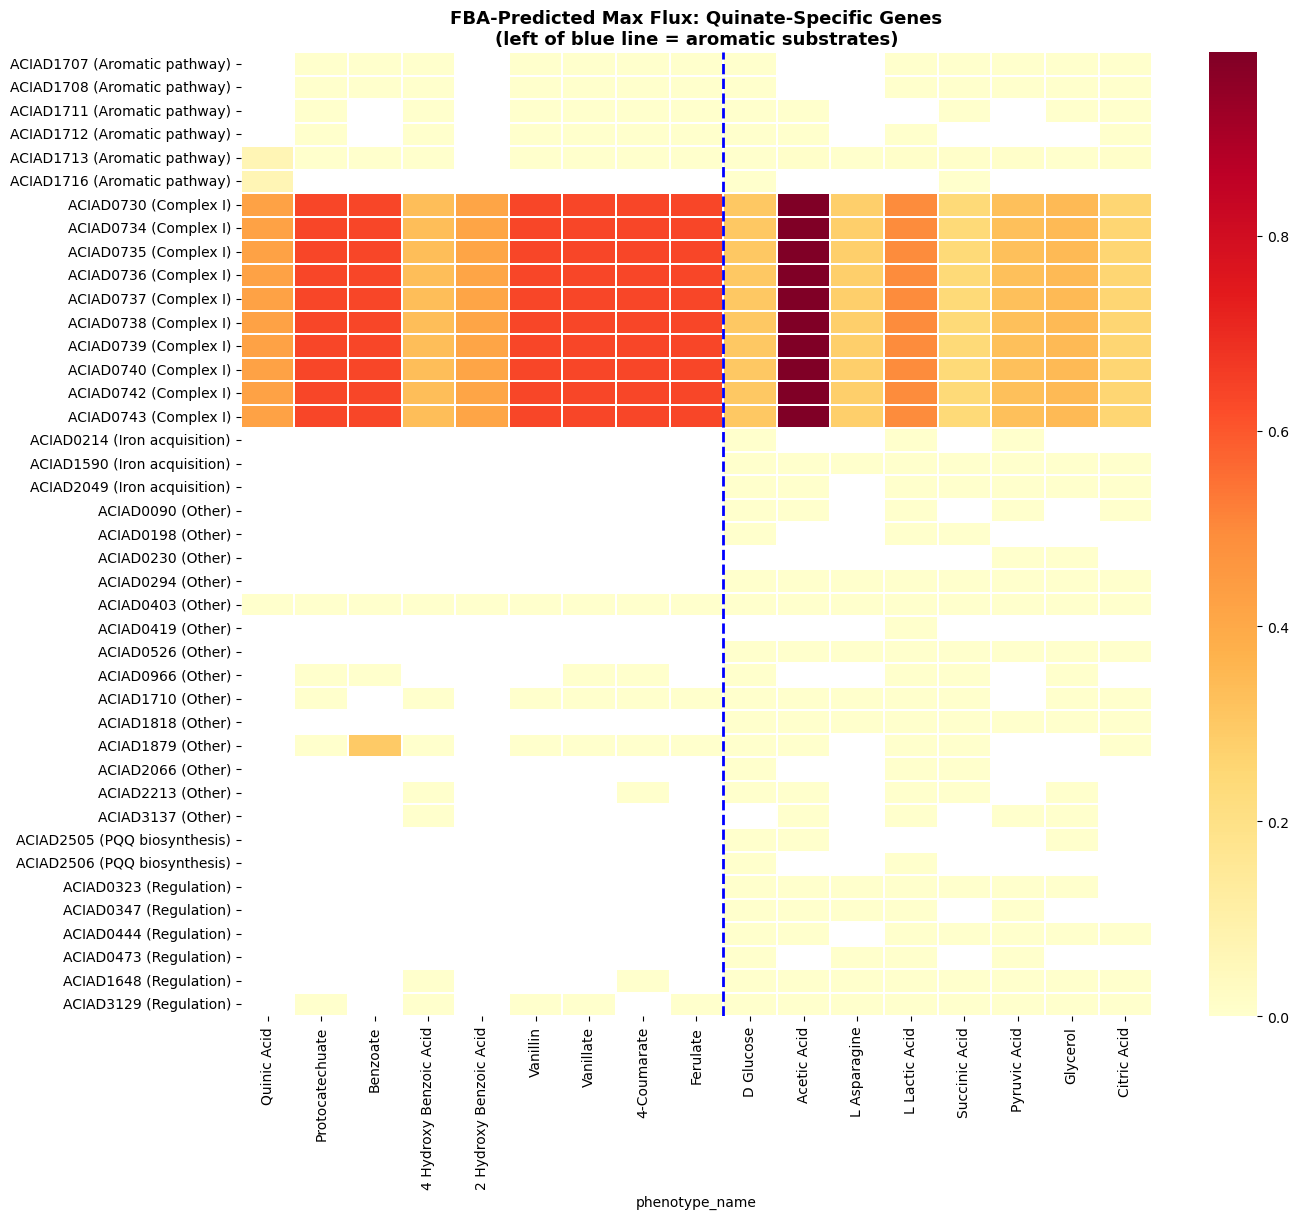

Saved: figures/fba_flux_heatmap.png


In [5]:
# Heatmap: FBA-predicted flux for each gene × condition
# Pivot to gene × condition matrix
flux_matrix = fba.pivot_table(
    index='gene_id', columns='phenotype_name', values='model_pred_max_flux', aggfunc='first'
)

# Add category labels
gene_cats = qs.set_index('feature_id')['category']
flux_matrix['category'] = flux_matrix.index.map(gene_cats)
flux_matrix = flux_matrix.sort_values('category')

# Create row labels
locus_map = qs.set_index('feature_id')['old_locus_tag']
row_labels = [f"{locus_map.get(g, g)} ({gene_cats.get(g, '?')})" 
              for g in flux_matrix.index]

# Select columns in order: aromatics first, then non-aromatics
aromatic_cols = [c for c in AROMATIC_CONDITIONS if c in flux_matrix.columns]
non_aromatic_cols = [c for c in NON_AROMATIC_CONDITIONS if c in flux_matrix.columns]
plot_cols = aromatic_cols + non_aromatic_cols

plot_data = flux_matrix[plot_cols].copy()
plot_data.index = row_labels

if len(plot_data) > 0 and len(plot_cols) > 0:
    fig, ax = plt.subplots(figsize=(14, max(8, len(plot_data) * 0.3)))
    sns.heatmap(plot_data, cmap='YlOrRd', ax=ax, linewidths=0.3,
                yticklabels=True, xticklabels=True)
    
    # Add vertical line between aromatic and non-aromatic
    ax.axvline(len(aromatic_cols), color='blue', linewidth=2, linestyle='--')
    ax.set_title('FBA-Predicted Max Flux: Quinate-Specific Genes\n'
                 '(left of blue line = aromatic substrates)', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'fba_flux_heatmap.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: figures/fba_flux_heatmap.png')
else:
    print('No flux data available for heatmap')

In [6]:
# Key test: do the support genes (Complex I, iron, PQQ) have HIGHER flux
# on aromatic substrates than non-aromatic?

support_categories = ['Complex I', 'Iron acquisition', 'PQQ biosynthesis']
support_genes = qs[qs['category'].isin(support_categories)]['feature_id'].tolist()
pathway_genes = qs[qs['category'] == 'Aromatic pathway']['feature_id'].tolist()

fba_support = fba[fba['gene_id'].isin(support_genes)].copy()
fba_pathway = fba[fba['gene_id'].isin(pathway_genes)].copy()

print('=== Does FBA predict aromatic-specific flux for support genes? ===')
print()

for label, df_sub in [('Pathway genes', fba_pathway), ('Support genes', fba_support)]:
    arom = df_sub[df_sub['is_aromatic']]['model_pred_max_flux']
    non_arom = df_sub[~df_sub['is_aromatic']]['model_pred_max_flux']
    print(f'{label}:')
    print(f'  Aromatic flux:     mean={arom.mean():.4f}  median={arom.median():.4f}  n={len(arom)}')
    print(f'  Non-aromatic flux: mean={non_arom.mean():.4f}  median={non_arom.median():.4f}  n={len(non_arom)}')
    if arom.mean() > 0 and non_arom.mean() > 0:
        ratio = arom.mean() / non_arom.mean()
        print(f'  Aromatic/non-aromatic ratio: {ratio:.2f}')
    print()

=== Does FBA predict aromatic-specific flux for support genes? ===

Pathway genes:
  Aromatic flux:     mean=0.0044  median=0.0000  n=35
  Non-aromatic flux: mean=0.0017  median=0.0000  n=31
  Aromatic/non-aromatic ratio: 2.55

Support genes:
  Aromatic flux:     mean=0.5544  median=0.6358  n=90
  Non-aromatic flux: mean=0.3143  median=0.2805  n=103
  Aromatic/non-aromatic ratio: 1.76



## 3. Fitness Browser Aromatic Experiment Survey

Quick feasibility check: do any of the 48 FB organisms have fitness data from aromatic carbon source experiments?

In [7]:
conn = sqlite3.connect(DB_PATH)

# The FB experiment data isn't in the SQLite — it's in BERDL.
# But we can check what organisms are available and note this for NB04.
# For now, list the phenotype_names that are aromatic in gene_phenotypes
# and check if any organisms have fitness_match != 'no_fitness_ortholog'

aromatic_fitness = pd.read_sql_query('''
    SELECT phenotype_name, fitness_match, COUNT(*) as n_genes,
           AVG(CASE WHEN fitness_avg IS NOT NULL THEN CAST(fitness_avg AS FLOAT) END) as mean_fitness
    FROM gene_phenotypes
    WHERE phenotype_name IN ('Quinic Acid', 'Protocatechuate', 'Benzoate', 
                             '4 Hydroxy Benzoic Acid', 'Vanillin')
    GROUP BY phenotype_name, fitness_match
''', conn)

print('=== Aromatic Phenotypes: Fitness Data Availability ===')
print(aromatic_fitness.to_string(index=False))

# Check if any have actual fitness data (not 'no_fitness_ortholog')
has_fitness = aromatic_fitness[aromatic_fitness['fitness_match'] != 'no_fitness_ortholog']
if len(has_fitness) > 0:
    print(f'\nAromatic conditions with fitness data: {has_fitness["phenotype_name"].unique().tolist()}')
else:
    print('\nNo aromatic conditions have ortholog-transferred fitness data.')
    print('Cross-species validation (NB04) will need to query BERDL directly.')

conn.close()

=== Aromatic Phenotypes: Fitness Data Availability ===
        phenotype_name                 fitness_match  n_genes  mean_fitness
4 Hydroxy Benzoic Acid                     has_score      729     -0.654676
4 Hydroxy Benzoic Acid           no_fitness_ortholog      441           NaN
4 Hydroxy Benzoic Acid   no_score_for_gene_phenotype      113           NaN
              Benzoate                     has_score      451     -0.970515
              Benzoate           no_fitness_ortholog      437           NaN
              Benzoate   no_score_for_gene_phenotype      151           NaN
       Protocatechuate                     has_score      385     -1.239600
       Protocatechuate           no_fitness_ortholog      438           NaN
       Protocatechuate   no_score_for_gene_phenotype      153           NaN
           Quinic Acid no_fitness_data_for_phenotype      758           NaN
              Vanillin                     has_score      529     -1.043269
              Vanillin           

## 4. Summary Table: The Support Network

In [8]:
# Create a summary table of the 51 genes with their categories and key properties
summary = qs[['feature_id', 'old_locus_tag', 'gene_names', 'category', 
              'rast_function', 'ko', 'ec',
              'specificity_quinate', 'zscore_quinate',
              'mutant_growth_quinate']].copy()

summary['biochemical_dependency'] = summary['category'].map({
    'Aromatic pathway': 'Core: ring cleavage & funneling to TCA',
    'Complex I': 'NADH reoxidation: TCA cycle generates excess NADH from aromatic catabolism',
    'PQQ biosynthesis': 'Cofactor: PQQ required by quinate dehydrogenase (quiA)',
    'Iron acquisition': 'Cofactor: Fe²⁺ required by protocatechuate 3,4-dioxygenase (pcaGH)',
    'Regulation': 'Regulatory: transcriptional control of aromatic degradation operons',
    'Unknown': 'Unknown: potential new pathway component',
    'Other': 'Indirect: possible pleiotropic or indirect effect'
})

summary = summary.sort_values(['category', 'specificity_quinate'], ascending=[True, False])

print('=== Aromatic Catabolism Support Network: 51 Genes ===')
print(f'{"Category":<20s} {"Count":>5s}  Biochemical rationale')
print('-' * 80)
for cat in ['Aromatic pathway', 'Complex I', 'PQQ biosynthesis', 
            'Iron acquisition', 'Regulation', 'Other', 'Unknown']:
    n = (summary['category'] == cat).sum()
    rationale = summary[summary['category'] == cat]['biochemical_dependency'].iloc[0] if n > 0 else ''
    print(f'{cat:<20s} {n:>5d}  {rationale}')

# Save
summary.to_csv(os.path.join(DATA_DIR, 'support_network_genes.csv'), index=False)
print(f'\nSaved: data/support_network_genes.csv ({len(summary)} genes)')

=== Aromatic Catabolism Support Network: 51 Genes ===
Category             Count  Biochemical rationale
--------------------------------------------------------------------------------
Aromatic pathway         6  Core: ring cleavage & funneling to TCA
Complex I               10  NADH reoxidation: TCA cycle generates excess NADH from aromatic catabolism
PQQ biosynthesis         2  Cofactor: PQQ required by quinate dehydrogenase (quiA)
Iron acquisition         4  Cofactor: Fe²⁺ required by protocatechuate 3,4-dioxygenase (pcaGH)
Regulation               6  Regulatory: transcriptional control of aromatic degradation operons
Other                   20  Indirect: possible pleiotropic or indirect effect
Unknown                  3  Unknown: potential new pathway component

Saved: data/support_network_genes.csv (51 genes)


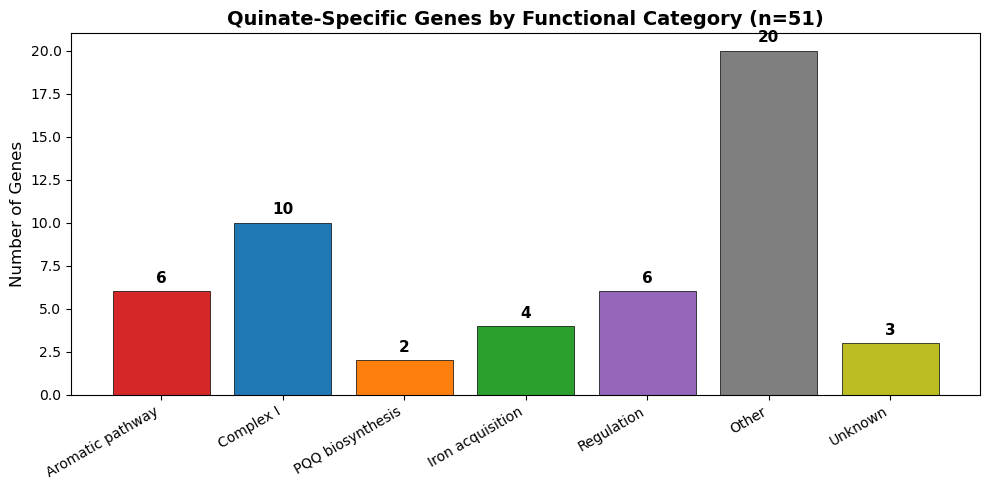

Saved: figures/support_network_categories.png


In [9]:
# Visualize the support network as a bar chart by category
cat_counts = summary['category'].value_counts()
cat_order = ['Aromatic pathway', 'Complex I', 'PQQ biosynthesis', 
             'Iron acquisition', 'Regulation', 'Other', 'Unknown']
cat_colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#7f7f7f', '#bcbd22']

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar([c for c in cat_order if c in cat_counts.index],
              [cat_counts.get(c, 0) for c in cat_order if c in cat_counts.index],
              color=[cat_colors[i] for i, c in enumerate(cat_order) if c in cat_counts.index],
              edgecolor='black', linewidth=0.5)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Number of Genes', fontsize=12)
ax.set_title('Quinate-Specific Genes by Functional Category (n=51)',
             fontsize=14, fontweight='bold')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'support_network_categories.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/support_network_categories.png')

In [10]:
print('\n=== NB01 Summary ===')
print(f'Quinate-specific genes analyzed: {len(qs)}')
print(f'  Aromatic pathway: {(qs["category"]=="Aromatic pathway").sum()}')
print(f'  Complex I: {(qs["category"]=="Complex I").sum()}')
print(f'  PQQ biosynthesis: {(qs["category"]=="PQQ biosynthesis").sum()}')
print(f'  Iron acquisition: {(qs["category"]=="Iron acquisition").sum()}')
print(f'  Regulation: {(qs["category"]=="Regulation").sum()}')
print(f'  Other/Unknown: {((qs["category"]=="Other") | (qs["category"]=="Unknown")).sum()}')
print(f'\nGenes with FBA reaction mappings: {len(genes_with_rxns)} / {len(qs)}')
print(f'Genes without (support genes): {len(genes_without)}')
print(f'\nFBA predictions across {len(all_conditions)} conditions:')
print(f'  Aromatic conditions: {len(AROMATIC_CONDITIONS)}')
print(f'  Non-aromatic conditions: {len(NON_AROMATIC_CONDITIONS)}')


=== NB01 Summary ===
Quinate-specific genes analyzed: 51
  Aromatic pathway: 6


  Complex I: 10
  PQQ biosynthesis: 2
  Iron acquisition: 4
  Regulation: 6
  Other/Unknown: 23

Genes with FBA reaction mappings: 21 / 51
Genes without (support genes): 30

FBA predictions across 17 conditions:
  Aromatic conditions: 9
  Non-aromatic conditions: 8
